In [1]:
% matplotlib inline

from scikits.talkbox.features import mfcc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import soundfile as sf
import pyaudio as pa
import os

random_state=24

音声ファイルimport

In [3]:
files = []
datapath = '../cry_data/wav_data/'

for x in os.listdir(datapath):  
    if '.wav' in x:
        files.append(x)

分割に関する関数定義

In [22]:
import scipy.fftpack
def smoothing_fft(abs_cry_array):
    N = len(abs_cry_array)
    fc = 0.001
    
    F = np.fft.fft(abs_cry_array)/(N/2)
    
    freq = np.fft.fftfreq(len(abs_cry_array))
    
    F[0] = F[0]/2
    
    F[(freq > fc)] = 0
    F[(freq < 0)] = 0
    
    f2 = np.fft.ifft(F)*(2*N/2)
    
    return f2

def smoothing_ave(abs_cry_array, width=100):
    # array_sizeはwidth分小さくなる
    smoothed_array = []
    for i in range((width / 2),len(abs_cry_array) - (width/2)):
        smoothed_array.append(np.mean(abs_cry_array[i - (width/2):i + (width/2) + 1]))
    return np.array(smoothed_array)

def devide_cry_by_value(cry_array):
    # cry_arrayの絶対値をとって平滑化
    width=100
    bottom_limit = 0.01
    standard_order = 300
    magni = 2
    length_limit = 2048
    
    smoothed_abs_cry_array = smoothing_fft(smoothing_ave(np.abs(cry_array), width))
    # bottom_limit以上で下からstandard_order番目の値を静音の基準に
    standard = smoothed_abs_cry_array[smoothed_abs_cry_array > bottom_limit].copy()
    standard.sort()
    standard = standard[standard_order]
    standard = standard * magni
    
    index_array = np.where(smoothed_abs_cry_array > standard)[0]
    
    if len(index_array) < 1:
        return None
    
    # width分修正
    index_array = index_array + (width / 2)
    # index_arrayを、塊ごとに分割
    devided_cry_array = []
    start = index_array[0]
    end = index_array[0]
    
    for ix in index_array[1:]:
        if ix == end + 1:
            end = ix
        else:
            cry_block = cry_array[start:end]
            if len(cry_block) > length_limit:
                devided_cry_array.append(cry_block)
            start = ix
            end = ix
    return devided_cry_array

"""def devide_cry(cry_array, dist=10, thred=0.0002, loop=10):
    # 0を削除
    #cry_array = cry_array[cry_array > 1e-10]
    
    # 傾きのリストをつくる
    smoothed_abs_cry_array = smoothing(np.abs(cry_array))
    dx_array = [(smoothed_abs_cry_array[i + dist] - smoothed_abs_cry_array[i]) / dist for i in range(len(smoothed_abs_cry_array) - dist)]
    dx_array = dx_array + [dx_array[-1]] * dist
    
    devided_cry_list = []
    start_ix = 0
    end_ix=0
    
    #for i in range(len(dx_array)):
        
    
    return dx_array"""

'def devide_cry(cry_array, dist=10, thred=0.0002, loop=10):\n    # 0\xe3\x82\x92\xe5\x89\x8a\xe9\x99\xa4\n    #cry_array = cry_array[cry_array > 1e-10]\n    \n    # \xe5\x82\xbe\xe3\x81\x8d\xe3\x81\xae\xe3\x83\xaa\xe3\x82\xb9\xe3\x83\x88\xe3\x82\x92\xe3\x81\xa4\xe3\x81\x8f\xe3\x82\x8b\n    smoothed_abs_cry_array = smoothing(np.abs(cry_array))\n    dx_array = [(smoothed_abs_cry_array[i + dist] - smoothed_abs_cry_array[i]) / dist for i in range(len(smoothed_abs_cry_array) - dist)]\n    dx_array = dx_array + [dx_array[-1]] * dist\n    \n    devided_cry_list = []\n    start_ix = 0\n    end_ix=0\n    \n    #for i in range(len(dx_array)):\n        \n    \n    return dx_array'

data分割

In [23]:
for f in files:
    x, sample_rate = sf.read(datapath + f)
    devided_cry_array = devide_cry_by_value(x)
    if devided_cry_array is None:
        continue
    for i in range(len(devided_cry_array)):
        sf.write('devided_wav_data2/' + str(i) + '-' + f, devided_cry_array[i], sample_rate)

In [50]:
devided_cry_array = devide_cry_by_value(x_seq[1])

50


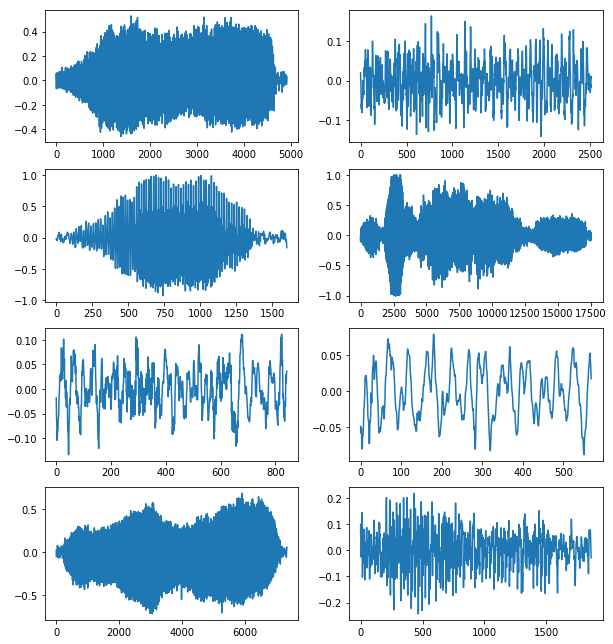

In [51]:
fig = plt.figure(figsize=(10,20))
for num in range(len(devided_cry_array)):
    plt.subplot(7,2,num + 1)
    plt.plot(devided_cry_array[num])
plt.show()

dataset作成

In [6]:
label_dict = {'hu':0, 'ti':1, 'dc':2}

X = []
y = []
x_seq = []
for f in files:
    x, sample_rate = sf.read(datapath + f)
    x_seq.append(x)
    x = np.clip(x, 1e-10, 1)
    ceps,mspec,spec = mfcc(x, nwin=256, nfft=512, fs=8000, nceps=13)
    X.append(np.mean(ceps, axis=0))
    if '-hu.' in f:
        y.append(label_dict['hu'])
    elif '-ti.' in f:
        y.append(label_dict['ti'])
    else:
        y.append(label_dict['dc'])

X = np.array(X)
y = np.array(y)

In [41]:
devide_cry_by_value(x_seq[0])

[array([ 0.2227478 ,  0.22988892,  0.19735718, ...,  0.02011108,
         0.00756836, -0.00836182]),
 array([ 0.01367188,  0.01715088,  0.02029419, ..., -0.00558472,
         0.01309204,  0.02563477]),
 array([  2.09960938e-02,   5.58471680e-03,   3.50952148e-03,
         -9.64355469e-03,  -1.81884766e-02,  -3.53088379e-02,
         -4.21142578e-02,  -4.00390625e-02,  -3.44238281e-02,
         -2.24609375e-02,  -2.40173340e-02,  -2.82287598e-02,
         -2.43835449e-02,  -1.15356445e-02,   1.07116699e-02,
          2.58789062e-02,   2.31323242e-02,   1.56250000e-02,
          1.33666992e-02,   1.54418945e-02,   1.73034668e-02,
          1.90124512e-02,   1.74560547e-02,   1.04064941e-02,
         -3.72314453e-03,  -1.31225586e-02,  -1.14135742e-02,
         -6.74438477e-03,  -8.14819336e-03,  -6.86645508e-03,
         -5.70678711e-03,  -6.74438477e-03,  -5.79833984e-03,
          3.81469727e-03,   1.79443359e-02,   3.48815918e-02,
          3.71398926e-02,   3.09143066e-02,   2.529907

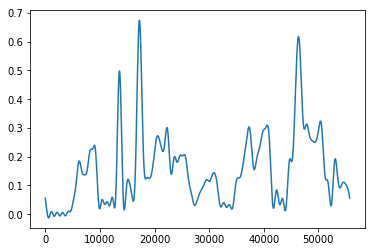

In [14]:
plt.plot(smoothing_fft(smoothing_ave(np.abs(x_seq[1]))))
plt.show()

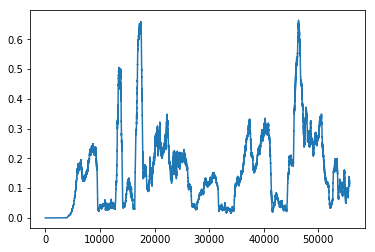

In [8]:
plt.plot(smoothing_ave(np.abs(x_seq[1])))
plt.show()

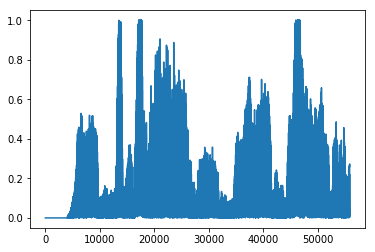

In [9]:
plt.plot(np.abs(x_seq[1]))
plt.show()

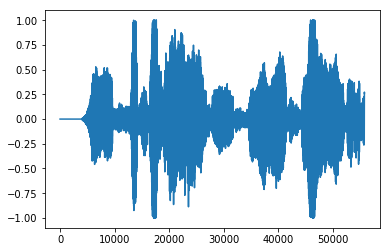

In [10]:
plt.plot(x_seq[1])
plt.show()